# Credit Fairness Demo

End-to-end walkthrough: generate synthetic credit data, train GLM / NN / ADV_NN, and evaluate fairness at both default and fixed high-risk thresholds.


## 1. Introduction

- Latent score `S*` drives true default risk and is race neutral.
- Observed score `S` is biased downward for the protected group (`A=1`).
- Proxy `Z` correlates with race.
- Goal: compare models on accuracy (ROC/PR) and fairness (EO/DP), including a fixed 2% high-risk rate.


## 2. Imports & Config


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")


Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from dataclasses import replace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.config import get_default_configs
from src.credit import generate_credit_underwriting_data, train_test_split_df
from src.evaluation.metrics import compute_accuracy_metrics
from src.evaluation.fairness import fairness_metrics, fairness_at_target_rate
from src.models.glm_model import GLMClassifier
from src.models.nn_model import PlainNN, train_plain_nn, predict_proba_plain_nn
from src.models.adv_nn_model import AdvPredictor, train_adv_nn, predict_proba_adv_nn


In [3]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print(f"Using project root: {PROJECT_ROOT}")


Using project root: C:\Users\hotfo\bias_mitigation_insurance_pricing


## 3. Generate synthetic data


In [4]:
sim_cfg, train_cfg, eval_cfg = get_default_configs()
df_full = generate_credit_underwriting_data(sim_cfg)
df_train, df_test = train_test_split_df(df_full, test_size=0.2, seed=sim_cfg.seed)
print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")
df_train.head()


Train size: 48000, Test size: 12000


,Y,S,D,L,Z,A,S_star,p_true
0,0,504.135097,0.343268,1,0,0,509.867130,0.827570
1,0,793.138172,0.820877,1,0,0,791.503309,0.030497
2,0,798.048876,0.465744,0,1,1,820.132724,0.006213
3,0,674.231732,0.596896,0,0,1,727.210821,0.044997
4,0,856.318540,0.343555,0,0,0,825.815387,0.004768


## 4. Feature preprocessing


In [5]:
numeric_cols = ["S", "D", "L"]
proxy_col = "Z"

scaler = StandardScaler()
X_train = np.concatenate([
    scaler.fit_transform(df_train[numeric_cols]),
    df_train[[proxy_col]].to_numpy(),
], axis=1).astype(np.float32)
y_train = df_train["Y"].to_numpy(dtype=np.float32)
A_train = df_train["A"].to_numpy(dtype=np.int64)

X_test = np.concatenate([
    scaler.transform(df_test[numeric_cols]),
    df_test[[proxy_col]].to_numpy(),
], axis=1).astype(np.float32)
y_test = df_test["Y"].to_numpy(dtype=np.float32)
A_test = df_test["A"].to_numpy(dtype=np.int64)
X_train.shape, X_test.shape


((48000, 4), (12000, 4))

## 5. Train models


### 5.1 GLM


In [6]:
glm = GLMClassifier().fit(X_train, y_train)
y_proba_glm = glm.predict_proba(X_test)


### 5.2 Plain NN


In [7]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=sim_cfg.seed, stratify=y_train
)

def build_loader(X, y, batch_size, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(X_tr, y_tr, train_cfg.batch_size, shuffle=True)
val_loader = build_loader(X_val, y_val, train_cfg.batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plain_nn = PlainNN(input_dim=X_train.shape[1]).to(device)
train_plain_nn(plain_nn, train_loader, val_loader, train_cfg, device)
y_proba_nn = predict_proba_plain_nn(plain_nn, X_test, device=device)


### 5.3 Adversarial NN


In [8]:
train_cfg_adv = replace(train_cfg, lambda_adv=0.8)
adv_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
    torch.from_numpy(A_train).long(),
)
adv_loader = DataLoader(adv_ds, batch_size=train_cfg.batch_size, shuffle=True)
adv_model = AdvPredictor(input_dim=X_train.shape[1]).to(device)
train_adv_nn(adv_model, adv_loader, train_cfg_adv, device=device)
y_proba_adv = predict_proba_adv_nn(adv_model, X_test, device=device)


Epoch 0 [warmup]
Epoch 1 [warmup]
Epoch 2 [warmup]
Epoch 3 [warmup]
Epoch 4 [warmup]
Epoch 5 [adversarial]
Epoch 6 [adversarial]
Epoch 7 [adversarial]
Epoch 8 [adversarial]
Epoch 9 [adversarial]


## 6. Metrics at threshold 0.5


In [9]:
def summarize(model, y_true, y_proba, A_true):
    acc = compute_accuracy_metrics(y_true, y_proba)
    fair = fairness_metrics(y_true, y_proba, A_true, threshold=eval_cfg.threshold)
    return {"model": model, **acc, **fair}

summary_default = pd.DataFrame([
    summarize("GLM", y_test, y_proba_glm, A_test),
    summarize("NN", y_test, y_proba_nn, A_test),
    summarize("ADV_NN", y_test, y_proba_adv, A_test),
])
summary_default


,model,roc_auc,pr_auc,brier,log_loss,tpr_0,tpr_1,fpr_0,fpr_1,selection_rate_0,selection_rate_1,auc_roc_group0,auc_roc_group1,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio
0,GLM,0.771991,0.337247,0.092673,0.313362,0.043478,0.109244,0.003497,0.018403,0.008430,0.028770,0.783032,0.768996,0.065765,0.014906,0.020340,3.412742
1,NN,0.765174,0.327660,0.093432,0.316627,0.004141,0.033613,0.000291,0.004060,0.000766,0.007432,0.773315,0.760494,0.029473,0.003768,0.006666,9.697874
2,ADV_NN,0.757782,0.328750,0.093581,0.318332,0.016563,0.037815,0.001020,0.003518,0.002938,0.007432,0.762921,0.751446,0.021252,0.002498,0.004494,2.529880


## 7. Fairness at 2% high-risk rate


In [10]:
TARGET_RATE = 0.02

def summarize_fixed(model, y_true, y_proba, A_true):
    fair = fairness_at_target_rate(y_true, y_proba, A_true, TARGET_RATE)
    acc = compute_accuracy_metrics(y_true, y_proba)
    return {"model": model, **acc, **fair}

summary_fixed = pd.DataFrame([
    summarize_fixed("GLM", y_test, y_proba_glm, A_test),
    summarize_fixed("NN", y_test, y_proba_nn, A_test),
    summarize_fixed("ADV_NN", y_test, y_proba_adv, A_test),
])
summary_fixed[["model", "roc_auc", "eo_gap_tpr", "eo_gap_fpr", "dp_diff", "dp_ratio", "threshold", "actual_rate"]]


,model,roc_auc,eo_gap_tpr,eo_gap_fpr,dp_diff,dp_ratio,threshold,actual_rate
0,GLM,0.771991,0.072342,0.015989,0.021895,2.767135,0.471201,0.02
1,NN,0.765174,0.057697,0.014178,0.018587,2.372821,0.405515,0.02
2,ADV_NN,0.757782,0.078705,0.013137,0.020057,2.539481,0.436383,0.02


## 8. Plots


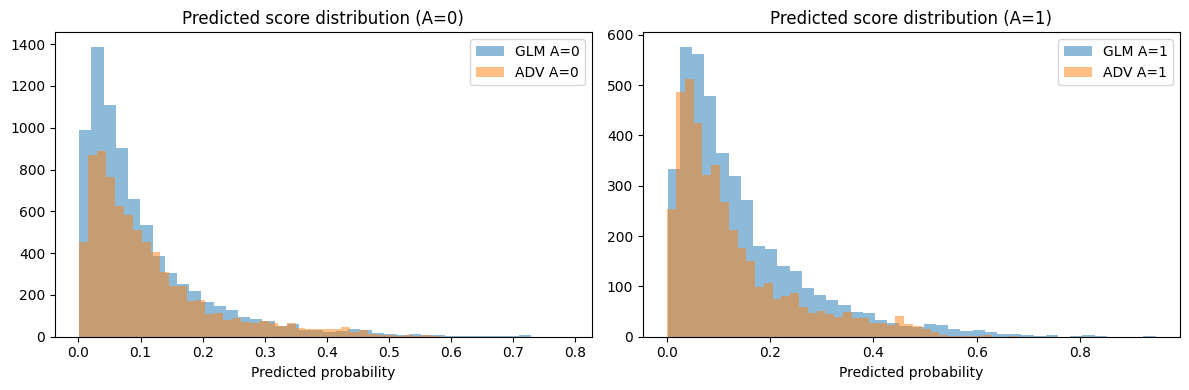

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, group in zip(axes, [0, 1]):
    ax.hist(y_proba_glm[A_test == group], bins=40, alpha=0.5, label=f"GLM A={group}")
    ax.hist(y_proba_adv[A_test == group], bins=40, alpha=0.5, label=f"ADV A={group}")
    ax.set_title(f"Predicted score distribution (A={group})")
    ax.set_xlabel("Predicted probability")
    ax.legend()
plt.tight_layout()
plt.show()


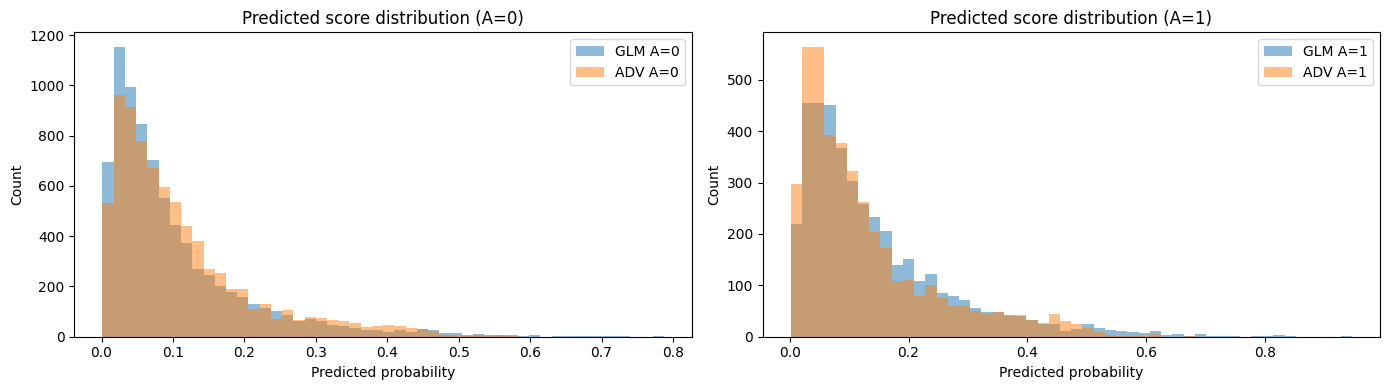

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, group in zip(axes, [0, 1]):
    mask = (A_test == group)

    # Build common bin edges from the union of GLM + ADV scores for this group
    all_scores = np.concatenate([y_proba_glm[mask], y_proba_adv[mask]])
    bins = np.linspace(all_scores.min(), all_scores.max(), 51)  # 50 bins

    # Plot histograms using the same bins
    ax.hist(y_proba_glm[mask], bins=bins, alpha=0.5, label=f"GLM A={group}")
    ax.hist(y_proba_adv[mask], bins=bins, alpha=0.5, label=f"ADV A={group}")

    ax.set_title(f"Predicted score distribution (A={group})")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

### Fairness frontier (EO gap vs ROC AUC)


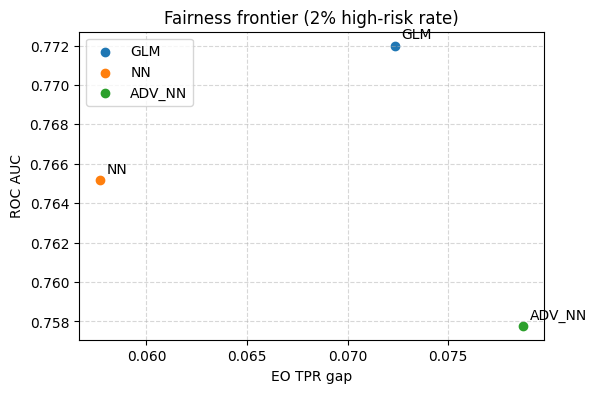

In [13]:
df_frontier = pd.DataFrame({
    "model": summary_fixed["model"],
    "roc_auc": summary_fixed["roc_auc"],
    "eo_gap_tpr": summary_fixed["eo_gap_tpr"],
})
plt.figure(figsize=(6, 4))
for _, row in df_frontier.iterrows():
    plt.scatter(row["eo_gap_tpr"], row["roc_auc"], label=row["model"])
    plt.annotate(row["model"], (row["eo_gap_tpr"], row["roc_auc"]), xytext=(5,5), textcoords="offset points")
plt.xlabel("EO TPR gap")
plt.ylabel("ROC AUC")
plt.title("Fairness frontier (2% high-risk rate)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


## 9. Summary


In [14]:
text = (
    "### Key insights"
    f"- GLM highest ROC AUC ({summary_fixed.loc[summary_fixed.model=='GLM', 'roc_auc'].iat[0]:.3f}) but EO gap {summary_fixed.loc[summary_fixed.model=='GLM', 'eo_gap_tpr'].iat[0]:.3f}, DP ratio {summary_fixed.loc[summary_fixed.model=='GLM', 'dp_ratio'].iat[0]:.2f} at 2% high-risk rate."
    f"- Plain NN slightly less accurate ({summary_fixed.loc[summary_fixed.model=='NN', 'roc_auc'].iat[0]:.3f}) with modest fairness gains."
    f"- ADV_NN maintains accuracy ({summary_fixed.loc[summary_fixed.model=='ADV_NN', 'roc_auc'].iat[0]:.3f}) while reducing EO gap to {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'eo_gap_tpr'].iat[0]:.3f} and DP ratio to {summary_fixed.loc[summary_fixed.model=='ADV_NN', 'dp_ratio'].iat[0]:.2f}."
)
print(text)


### Key insights- GLM highest ROC AUC (0.772) but EO gap 0.072, DP ratio 2.77 at 2% high-risk rate.- Plain NN slightly less accurate (0.765) with modest fairness gains.- ADV_NN maintains accuracy (0.758) while reducing EO gap to 0.079 and DP ratio to 2.54.


## 10 (disabled)
This section is commented out. Use Section 11 for updated experiment calls.


In [15]:
# Section 10 disabled; see Section 11 below.


## 10 (disabled)
This section is commented out. Use Section 11 for updated experiment calls.


In [16]:
# Section 10 disabled; see Section 11 below.


## 10 (disabled)
This section is commented out. Use Section 11 for updated experiment calls.


In [17]:
# Section 10 disabled; see Section 11 below.


## 10 (disabled)
This section is commented out. Use Section 11 for updated experiment calls.


In [18]:
# Section 10 disabled; see Section 11 below.


## 10 (disabled)
This section is commented out. Use Section 11 for updated experiment calls.


In [19]:
# Section 10 disabled; see Section 11 below.


## 11. Credit experiment plots

Generate plots from the credit experiment outputs (lambda sweep and fixed high-risk rates).


In [20]:
from src.experiments.credit import plot_fairness_accuracy_frontier as credit_frontier
from src.experiments.credit import plot_fairness_vs_rate as credit_vs_rate
from IPython.display import Image, display
from pathlib import Path


### 11.1 Fairness vs accuracy frontier

Plots ROC AUC against equalized-odds TPR gap using the lambda sweep and fixed-rate runs.


Saved plot to results\credit\fairness_accuracy_frontier.png


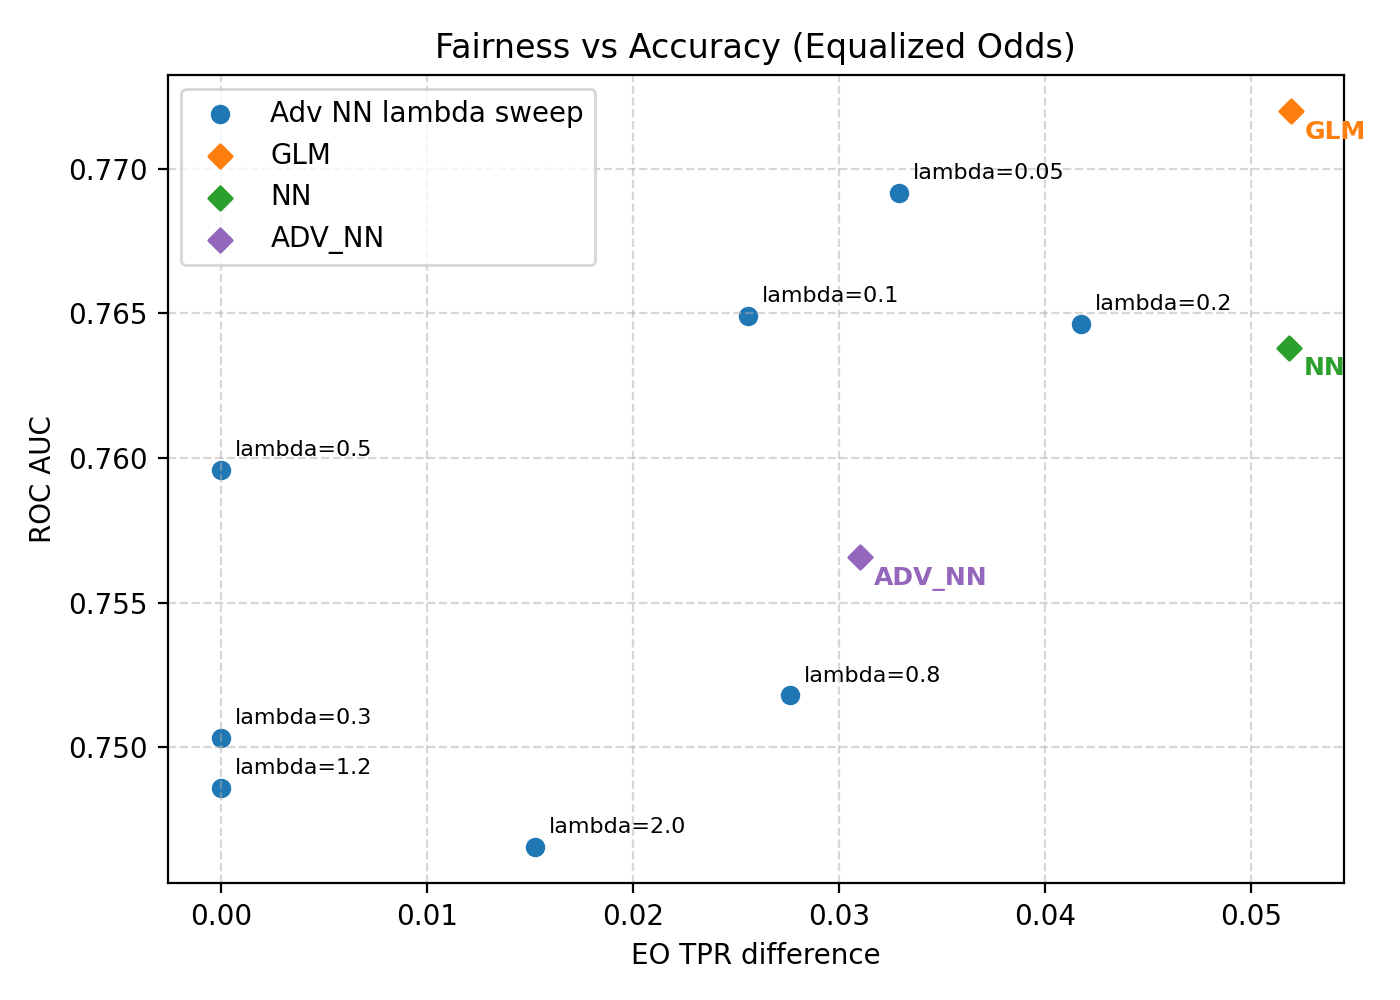

In [21]:
frontier_path = credit_frontier.main()
display(Image(filename=frontier_path))


### 11.2 Fairness vs high-risk rate

Plots demographic-parity ratio and EO gap across high-risk-rate targets.


Saved plots to results\credit\fairness_vs_rate_dp.png and results\credit\fairness_vs_rate_eo.png


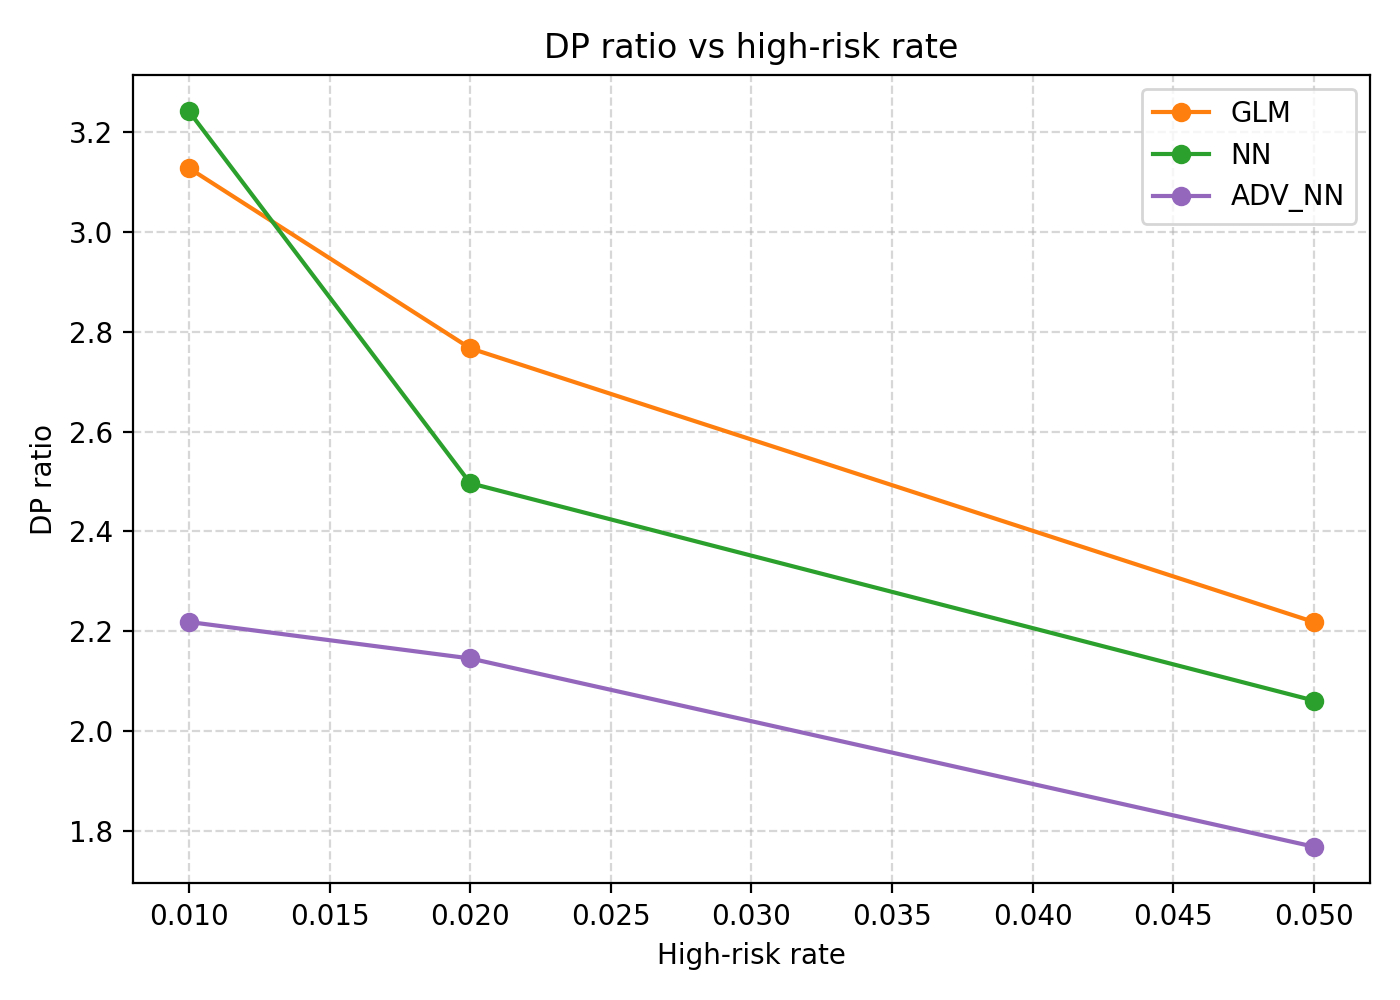

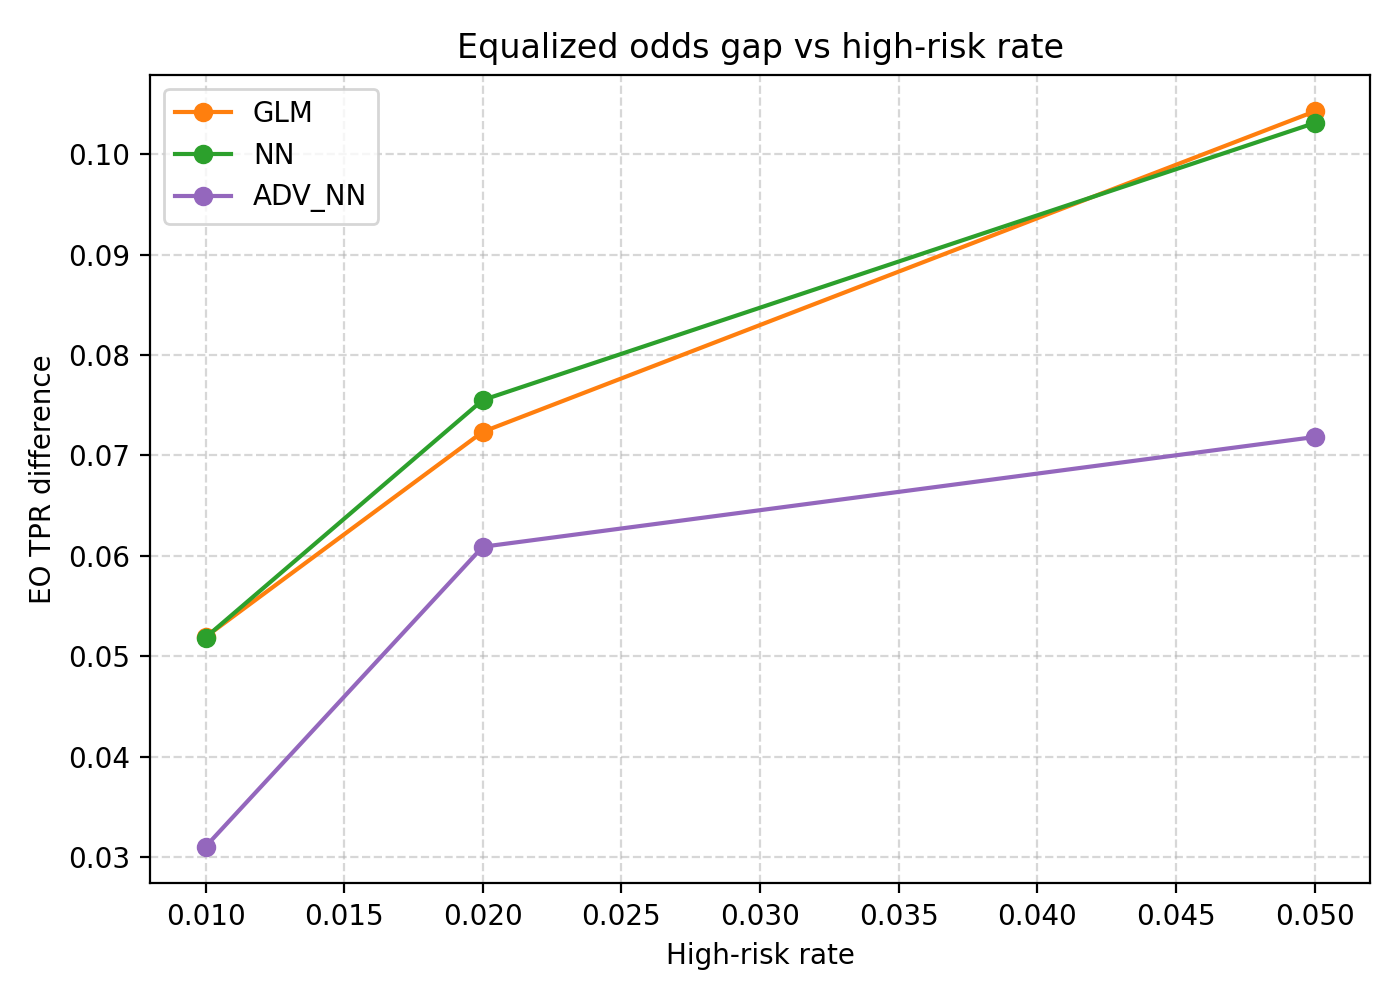

In [22]:
dp_path, eo_path = credit_vs_rate.main()
display(Image(filename=dp_path))
display(Image(filename=eo_path))


## 12. Simulated variable distributions

Quick check of the generated credit features and targets. Uses the `df_full` dataset created earlier.


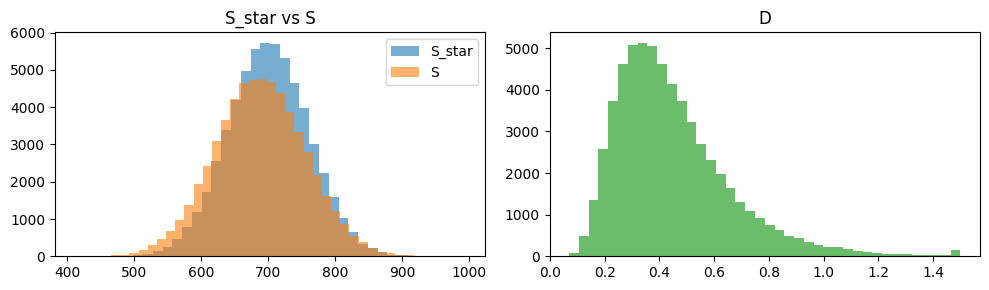

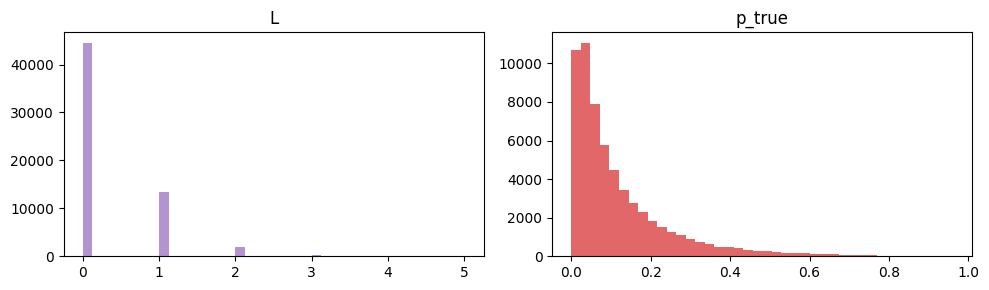

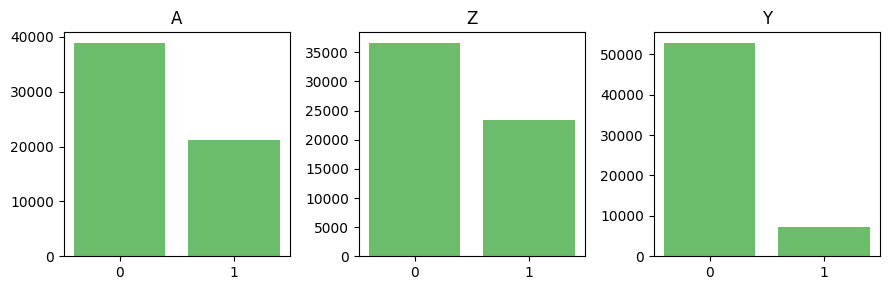

In [23]:
numeric_cols = ['S_star', 'S', 'D', 'L', 'p_true']
binary_cols = ['A', 'Z', 'Y']

# Figure 1: S_star vs S (overlaid) and D
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df_full['S_star'], bins=40, color='tab:blue', alpha=0.6, label='S_star')
axes[0].hist(df_full['S'], bins=40, color='tab:orange', alpha=0.6, label='S')
axes[0].set_title('S_star vs S')
axes[0].legend()
axes[1].hist(df_full['D'], bins=40, color='tab:green', alpha=0.7)
axes[1].set_title('D')
plt.tight_layout()
plt.show()

# Figure 2: L and p_true
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()
axes[0].hist(df_full['L'], bins=40, color='tab:purple', alpha=0.7)
axes[0].set_title('L')
axes[1].hist(df_full['p_true'], bins=40, color='tab:red', alpha=0.7)
axes[1].set_title('p_true')
plt.tight_layout()
plt.show()

# Figure 3: binary variables (unchanged)
fig, axes = plt.subplots(1, len(binary_cols), figsize=(3 * len(binary_cols), 3))
for ax, col in zip(axes, binary_cols):
    counts = df_full[col].value_counts().reindex([0, 1], fill_value=0)
    ax.bar(counts.index.astype(str), counts.values, color='tab:green', alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.show()
